# Advanced Modeling of Groundwater Flow (GW3099)
![alt text](..\img\header.jpg)

# Exercise 2: MODFLOW 6
The purpose of this exercise is to use MODFLOW 6 to simulate example problem 1 using Flopy.

## Part I. Setup Notebook

In [1]:
from __future__ import print_function
%matplotlib inline
import sys
import os
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

import config

print(sys.version)
print('python executable: {}'.format(sys.executable))
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

Executable file found: Z:\langevin\training\AdvancedModeling2018\gw3099\gw3099_classrepo\exercises\bin\win64\mf2005.exe
Executable file found: Z:\langevin\training\AdvancedModeling2018\gw3099\gw3099_classrepo\exercises\bin\win64\mp7.exe
Executable file found: Z:\langevin\training\AdvancedModeling2018\gw3099\gw3099_classrepo\exercises\bin\win64\mt3dms.exe
Executable file found: Z:\langevin\training\AdvancedModeling2018\gw3099\gw3099_classrepo\exercises\bin\win64\mf6.exe
Executable file found: Z:\langevin\training\AdvancedModeling2018\gw3099\gw3099_classrepo\exercises\bin\win64\gridgen.exe
3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
python executable: Z:\langevin\training\AdvancedModeling2018\gw3099\Miniconda3\python.exe
numpy version: 1.15.2
matplotlib version: 2.2.2
flopy version: 3.2.9


## Part II. Create, Run, and Post-Process MODFLOW 6 Model

In [2]:
# model info
model_name = 'ex02'
model_ws = './ex02-completed'

# grid properties
nlay = 3
nrow = 21
ncol = 20
delr = 500.
delc = 500.
top = 400.
botm = [220., 200., 0.]

# hydraulic properties
hk0 = 50.
vk0 = 10.
hk1 = 0.01
vk1 = 0.01
hk2 = 200.
vk2 = 20

# boundary conditions
welspd = [[(3 - 1, 11 - 1, 10 - 1), -1.5e5]]
rech = 0.005
rivspd = [[(0, ir, ncol-1), 320., 1.e5, 318.] for ir in range(nrow)]

In [3]:
# create simulation
sim = flopy.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name=config.mf6exe, 
                             sim_ws=model_ws)

# create tdis package
tdis_rc = [(1000.0, 1, 1.0)]
tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', 
                             perioddata=tdis_rc)

# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
gwf.name_file.save_flows = True

# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim, pname='ims', print_option='SUMMARY', 
                           complexity='SIMPLE', outer_hclose=1.e-5, 
                           outer_maximum=100, under_relaxation='NONE', 
                           inner_maximum=100, inner_hclose=1.e-6, 
                           rcloserecord=0.1, linear_acceleration='BICGSTAB', 
                           scaling_method='NONE', reordering_method='NONE', 
                           relaxation_factor=0.99)
sim.register_ims_package(ims, [gwf.name])

# dis
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm)

# initial conditions
ic = flopy.mf6.ModflowGwfic(gwf, pname='ic', strt=320.)

# node property flow
npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=[('xt3d')],
                              save_specific_discharge=True,
                              icelltype=[1,0,0], 
                              k=[50.0, 0.01, 200.0],
                              k33=[10., 0.01, 20.])

# wel
wel = flopy.mf6.ModflowGwfwel(gwf, print_input=True,
                              stress_period_data=welspd)

# rch
aux = [np.ones((nrow, ncol), dtype=np.int)*6]
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.005, 
                               auxiliary=[('iface',)], 
                               aux={0: [6]})
# riv
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd)

# output control
oc = flopy.mf6.ModflowGwfoc(gwf, pname='oc', budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

sim.write_simulation()
sim.run_simulation()

Directory structure already exists for simulation path Z:\langevin\training\AdvancedModeling2018\gw3099\gw3099_classrepo\exercises\MODFLOW6\.\ex02-completed
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model ex02...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package wel...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package rcha...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: Z:\langevin\training\AdvancedModeling2018\gw3099\gw3099_classrepo\exercises\bin\win64\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
     

(True, [])

In [4]:
# Load binary grid file
fname = os.path.join(model_ws, model_name + '.dis.grb')
grd = flopy.utils.MfGrdFile(fname, verbose=False)
sr = grd.get_spatialreference()

# load the heads and budget files
fname = os.path.join(model_ws, model_name + '.hds')
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()

fname = os.path.join(model_ws, model_name + '.cbc')
cbb = flopy.utils.CellBudgetFile(fname, precision='double')
spdis = cbb.get_data(text='DATA-SPDIS')[0]
qx = spdis['qx'].reshape(nlay, nrow, ncol)
qy = spdis['qy'].reshape(nlay, nrow, ncol)
qz = spdis['qz'].reshape(nlay, nrow, ncol)

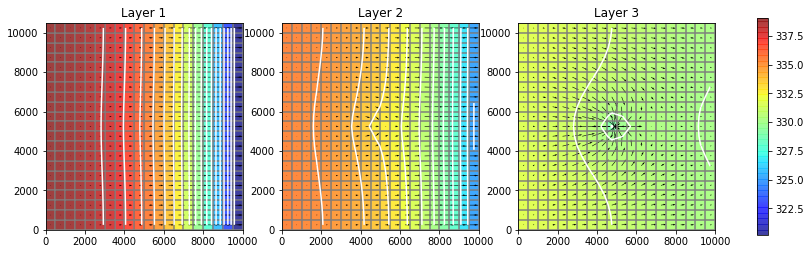

In [5]:
# plot the results for each layer
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
vmin = head.min()
vmax = head.max()
levels = np.linspace(vmin, vmax, 20)

for ilay in range(nlay):
    ax = axes[ilay]
    ax.set_title('Layer {}'.format(ilay + 1))
    ax.set_aspect('equal')
    modelmap = flopy.plot.ModelMap(sr=sr, layer=ilay, ax=ax)
    quadmesh = modelmap.plot_array(head, masked_values=[999.], alpha=0.5, 
                                   vmin=vmin, vmax=vmax, cmap='jet')
    linecollection = modelmap.plot_grid()
    contour_set = modelmap.contour_array(head, levels=levels, colors='white')
    quiver = ax.quiver(sr.xcentergrid, sr.ycentergrid, qx[ilay], qy[ilay])
cb = fig.colorbar(quadmesh, ax=axes, shrink=0.5)

## Part III. Create and Run MODPATH-7 Model

In [6]:
# particles
partlocs = [(0, i, 0) for i in range(nrow)]
particledata = flopy.modpath.ParticleData(partlocs, structured=True)
pg = flopy.modpath.ParticleGroup(particledata=particledata)

In [7]:
mp = flopy.modpath.Modpath7(modelname=model_name+'_mp', model_ws=model_ws, flowmodel=gwf, exe_name=config.mpexe)
mpbas = flopy.modpath.Modpath7Bas(mp)
mpsim = flopy.modpath.Modpath7Sim(mp, particlegroups=pg)
mp.write_input()
mp.run_model()

FloPy is using the following  executable to run the model: Z:\langevin\training\AdvancedModeling2018\gw3099\gw3099_classrepo\exercises\bin\win64\mp7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compiler (ver. 16.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+03  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         2 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
        19 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.             

(True, [])

In [8]:
# load the pathline results
fname = os.path.join(model_ws, model_name + '_mp.mppth')
p = flopy.utils.PathlineFile(fname).get_alldata()

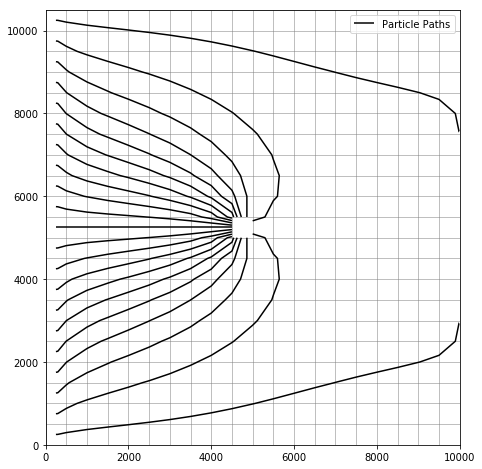

In [9]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
mm = flopy.plot.ModelMap(sr=sr)
mm.plot_grid(lw=0.5)
mm.plot_pathline(p, layer='all', colors='k', label='Particle Paths')
mm.ax.legend();